## Applying PINN to the PDE - 1D Version - Fourier Encoding

We are interessed in solving

$$
\frac{\partial \rho}{\partial t} = \nabla \cdot \left(\Sigma \nabla\rho(x,t) - \rho(x,t) F(\rho(x,t)) \right)

$$



Where $x=x_1$. $\Sigma = \rm{diag} (\sigma_1^2, \sigma_2^2)$. $F: \mathbb{R} \mapsto \mathbb{R}$, $F(\rho) = f(\rho).

On the domain

$$
\Omega = \{x \in [0,L]\}
$$

With boundary conditions

$$
j \cdot n = -a (\rho_{max} - \rho) \quad \forall x \in \Gamma_{in}
$$

$$
j \cdot n = b \rho \quad \forall x \in \Gamma_{out}
$$


where

$$
\Gamma_{in} = \{(x_1, x_2) \in \Omega: x_1 = 0\}
$$

$$
\Gamma_{out} = \{(x_1, x_2) \in \Omega: x_1 = L\}
$$


With $j = -\Sigma \nabla \rho + \rho F(\rho)$ and $n$ the outer normal vector, i.e. vector points toward the interior:

$$
n = -1 \quad \rm{for} \quad \Gamma_{in}
$$

$$
n = 1\quad \rm{for} \quad \Gamma_{out}
$$


In a more explicit manner, the PDE can be written as

$$
\frac{\partial \rho}{\partial t} = \sigma_1 \frac{\partial^2 \rho}{\partial x_1^2} - \frac{\partial \rho}{\partial x_1} \left(f(\rho(x,t)) + \rho(x,t) \frac{d f(\rho(x,t))}{d \rho} \right)
$$

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [33]:
# Correct that to import from the other file

from abc import ABC, abstractmethod

class FundamentalDiagram():
    def __init__(self, params):
        self.params = params

    def __call__(self,density):
        return self.flux(density)
    
    @abstractmethod
    def flux(self, density):
        pass

    @abstractmethod
    def __str__(self):
        pass



class Greenshield(FundamentalDiagram):
    def __init__(self, params):
        super().__init__(params)
        self.v_max = self.params[0]
        self.p_max = self.params[1]
    
    def flux(self, density):
        return self.v_max * (1 - (density/self.p_max))
    
    def d_flux(self, density):
        return - self.v_max/self.p_max + 0*density
    
    def __str__(self):
        return "Greenshield"

In [34]:
# input = (x1, x2, t)

In [35]:
sigma1 = 0.5*0.5
sigma2 = 0.5*0.5

L = 2
l = 0.5
T = 5

a = 0.8
b = 0.75


v_max = 1.2
p_max = 4

encoding_degree = 20

In [36]:
model_key = jax.random.PRNGKey(1)

input_dim = 4*encoding_degree+2
output_dim = 'scalar'

layers_size = 10
n_layers = 1

model = eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=layers_size, depth=n_layers,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

In [37]:
def fourier_encode(x, order):
    # Initialize the list to collect the Fourier encoded values
    encoded = [x[0], x[1]]
    for i in range(1, order + 1):
        factor = 2 ** i
        encoded.extend(jnp.sin(factor * x))
        encoded.extend(jnp.cos(factor * x))
    return jnp.array(encoded)

def batch_fourier_encode(batch, order):
    encode = lambda x: fourier_encode(x, order)
    return jax.vmap(encode)(batch)

In [38]:
# Example batch input

batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

In [39]:
fourier_encode(jnp.array([1.0, 2.0]), encoding_degree)

Array([ 1.        ,  2.        ,  0.9092974 , -0.7568025 , -0.41614684,
       -0.6536436 , -0.7568025 ,  0.98935825, -0.6536436 , -0.14550003,
        0.98935825, -0.2879033 , -0.14550003, -0.9576595 , -0.2879033 ,
        0.5514267 , -0.9576595 ,  0.8342234 ,  0.5514267 ,  0.92002606,
        0.8342234 ,  0.39185724,  0.92002606,  0.7210377 ,  0.39185724,
       -0.6928958 ,  0.7210377 , -0.99920803, -0.6928958 , -0.03979076,
       -0.99920803,  0.0795185 , -0.03979076, -0.9968334 ,  0.0795185 ,
       -0.15853338, -0.9968334 ,  0.9873536 , -0.15853338, -0.313057  ,
        0.9873536 ,  0.94973433, -0.313057  , -0.594642  ,  0.94973433,
        0.8039906 , -0.594642  , -0.9561732 ,  0.8039906 ,  0.29280183,
       -0.9561732 , -0.5599385 ,  0.29280183, -0.8285342 , -0.5599385 ,
        0.9278563 , -0.8285342 ,  0.37293783,  0.9278563 ,  0.6920655 ,
        0.37293783, -0.7218348 ,  0.6920655 , -0.9991138 , -0.7218348 ,
        0.04209081, -0.9991138 , -0.08410703,  0.04209081, -0.99

In [40]:
enconded_input = batch_fourier_encode(batch_input_data, encoding_degree)

In [41]:
enconded_input

Array([[ 1.        ,  2.        ,  0.9092974 , -0.7568025 , -0.41614684,
        -0.6536436 , -0.7568025 ,  0.98935825, -0.6536436 , -0.14550003,
         0.98935825, -0.2879033 , -0.14550003, -0.9576595 , -0.2879033 ,
         0.5514267 , -0.9576595 ,  0.8342234 ,  0.5514267 ,  0.92002606,
         0.8342234 ,  0.39185724,  0.92002606,  0.7210377 ,  0.39185724,
        -0.6928958 ,  0.7210377 , -0.99920803, -0.6928958 , -0.03979076,
        -0.99920803,  0.0795185 , -0.03979076, -0.9968334 ,  0.0795185 ,
        -0.15853338, -0.9968334 ,  0.9873536 , -0.15853338, -0.313057  ,
         0.9873536 ,  0.94973433, -0.313057  , -0.594642  ,  0.94973433,
         0.8039906 , -0.594642  , -0.9561732 ,  0.8039906 ,  0.29280183,
        -0.9561732 , -0.5599385 ,  0.29280183, -0.8285342 , -0.5599385 ,
         0.9278563 , -0.8285342 ,  0.37293783,  0.9278563 ,  0.6920655 ,
         0.37293783, -0.7218348 ,  0.6920655 , -0.9991138 , -0.7218348 ,
         0.04209081, -0.9991138 , -0.08410703,  0.0

In [42]:
func = Greenshield([v_max, p_max])

In [43]:
jax.vmap(jax.hessian(model))(enconded_input)

Array([[[-1.38546602e-04, -1.66013037e-04,  2.48849479e-04, ...,
         -2.84001260e-04,  2.82755413e-04, -1.38516800e-04],
        [-1.66013051e-04,  1.55116068e-05, -2.01402563e-05, ...,
         -1.67625785e-05, -8.70619988e-05, -1.41022838e-05],
        [ 2.48849508e-04, -2.01402545e-05, -5.34319151e-05, ...,
          7.48718667e-05, -1.64596695e-05, -3.38191094e-05],
        ...,
        [-2.84001260e-04, -1.67625749e-05,  7.48718594e-05, ...,
         -1.62017852e-04,  7.57717353e-05,  4.55808595e-06],
        [ 2.82755471e-04, -8.70620133e-05, -1.64596677e-05, ...,
          7.57717135e-05,  1.56380338e-05, -8.67375566e-05],
        [-1.38516800e-04, -1.41023047e-05, -3.38191130e-05, ...,
          4.55808186e-06, -8.67375493e-05, -1.36852832e-05]],

       [[-3.94520845e-04,  4.17200590e-06,  2.68873002e-04, ...,
         -4.21422330e-04,  3.02843982e-04, -1.38482446e-05],
        [ 4.17199772e-06, -2.13143852e-04,  7.50387044e-05, ...,
          1.23994751e-05, -2.16716649e

In [44]:
def pde_loss(model, func, input, sigma1):
    
    # p = rho

    rho, grad = jax.vmap(jax.value_and_grad(model))(input)
    hess = jax.vmap(jax.hessian(model))(input)

    dp_dx1 = grad[:, 0] 
    dp_dt = grad[:, 1]
    d2p_dx12 = hess[:, 0, 0]


    fp = func.flux(rho)
    df_p = func.d_flux(rho)

    rhs = sigma1*d2p_dx12 - dp_dx1 * (fp + rho*df_p)

    return jnp.mean((dp_dt - rhs)**2)

In [45]:
pde_loss(model, func, enconded_input,  sigma1=sigma1)

Array(0.00018884, dtype=float32)

In [46]:
enconded_input

Array([[ 1.        ,  2.        ,  0.9092974 , -0.7568025 , -0.41614684,
        -0.6536436 , -0.7568025 ,  0.98935825, -0.6536436 , -0.14550003,
         0.98935825, -0.2879033 , -0.14550003, -0.9576595 , -0.2879033 ,
         0.5514267 , -0.9576595 ,  0.8342234 ,  0.5514267 ,  0.92002606,
         0.8342234 ,  0.39185724,  0.92002606,  0.7210377 ,  0.39185724,
        -0.6928958 ,  0.7210377 , -0.99920803, -0.6928958 , -0.03979076,
        -0.99920803,  0.0795185 , -0.03979076, -0.9968334 ,  0.0795185 ,
        -0.15853338, -0.9968334 ,  0.9873536 , -0.15853338, -0.313057  ,
         0.9873536 ,  0.94973433, -0.313057  , -0.594642  ,  0.94973433,
         0.8039906 , -0.594642  , -0.9561732 ,  0.8039906 ,  0.29280183,
        -0.9561732 , -0.5599385 ,  0.29280183, -0.8285342 , -0.5599385 ,
         0.9278563 , -0.8285342 ,  0.37293783,  0.9278563 ,  0.6920655 ,
         0.37293783, -0.7218348 ,  0.6920655 , -0.9991138 , -0.7218348 ,
         0.04209081, -0.9991138 , -0.08410703,  0.0

In [47]:
def j(model, func, input, sigma1):
    rho, grad = jax.vmap(jax.value_and_grad(model))(input)

    i_0 = - sigma1*grad[:, 0] + rho * func(rho)

    return i_0, rho

In [48]:
def in_loss(model, func, T, sigma1, a, steps=20):

    t = jnp.linspace(0, T, steps)

    x1_flat = jnp.zeros_like(t)

    result = batch_fourier_encode(jnp.stack((x1_flat, t), axis=-1), encoding_degree)

    in_ , rho = j(model, func, result, sigma1)

    in_theorical = -a * (func.p_max - rho)




    return jnp.mean((-in_ - in_theorical)**2)


In [49]:
in_loss(model, func, T, sigma1, a)

Array(23.96913, dtype=float32)

In [50]:
def out_loss(model, func, T, sigma1, b, steps=20):

    t = jnp.linspace(0, T, steps)

    x1_flat = jnp.full_like(t, L)

    result = batch_fourier_encode(jnp.stack((x1_flat, t), axis=-1), encoding_degree)

    out_ , rho = j(model, func, result, sigma1)

    out_theorical = b * rho




    return jnp.mean((out_ - out_theorical)**2)

In [51]:
out_loss(model, func, T, sigma1, b)

Array(0.22628534, dtype=float32)

In [52]:
def time_loss(model, L, steps=20):

    x1 = jnp.linspace(0, L, steps)

    t_flat = jnp.zeros_like(x1)

    result = batch_fourier_encode(jnp.stack((x1, t_flat), axis=-1), encoding_degree)

    rho = jax.vmap(model)(result)

    return jnp.mean(rho**2)

In [53]:
time_loss(model, L)

Array(0.50719965, dtype=float32)

In [54]:
def loss(model, func, input, L, T, sigma1, a, b, steps=20):

    return (10*pde_loss(model, func, input,  sigma1) + in_loss(model, func, T, sigma1, a, steps) + 
            out_loss(model, func, T, sigma1, b, steps) + 
            0.01*time_loss(model, L, steps))

    #return time_loss(model, l, L, steps)

In [55]:
loss(model, func, enconded_input, L, T, sigma1, a, b)

Array(24.202375, dtype=float32)

In [238]:
# Define a Multilayer Perceptron With a Skip Connection

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.
    gate: eqx.nn.Linear  # Learnable gating mechanism


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 2)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

        # Skip connection
        self.gate = eqx.nn.Linear(1, 1, key=keys[-1]) # Linear layer for the third input

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """

        skip_connection = x # Copy of input


        for layer in self.layers[:-1]:
            x = jax.nn.sigmoid(layer(x))
            
        x = self.layers[-1](x)

        # Apply the skip connection

        gate_input = skip_connection[2].reshape(1, 1)  # Reshape to match gate input dimensions
        gate_output = self.gate(gate_input)

        x = x * gate_output

        return x.squeeze() 

In [68]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.swish(layer(x))
        x = self.layers[-1](x)
        return x

In [69]:
def generate_latin_hypercube_samples(num_samples, x1, t):
    # Define the ranges
    parameter_ranges = jnp.array([x1, t])
    
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=len(parameter_ranges))
    
    # Sample points in the hypercube
    sample_points = sampler.random(n=num_samples)
    
    # Scale the points
    scaled_samples = qmc.scale(sample_points, parameter_ranges[:, 0], parameter_ranges[:, 1])
    
    return jnp.array(scaled_samples)

In [70]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)


output_dim = 'scalar'

model = MLP(model_key, input_dim=4*encoding_degree+2, hidden_dims=500, n_layers=1, output_dim=output_dim)

In [71]:
# Optimizer definition
lr = 0.001
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

In [72]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, func, input, L, T, sigma1, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, func, input, L, T, sigma1, a, b, steps) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [73]:
# Training loop
num_epochs = 10000
losses = []



sample_n = 50
x = batch_fourier_encode(generate_latin_hypercube_samples(sample_n, [0,L], [0,T]), encoding_degree) # Latin Hypercube sample

sample_points = x.copy()

for epoch in range(num_epochs):
    
    model, opt_state, loss_value = train_step(model, opt_state, func, x, L, T, sigma1, a, b, steps=20)
    if epoch % 100 == 0:
        x = batch_fourier_encode(generate_latin_hypercube_samples(sample_n, [0,L], [0,T]), encoding_degree) # Latin Hypercube sample
        sample_points = jnp.vstack((sample_points, x))
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")


    if epoch % 1000 == 0:
        lr *= 0.75
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate

        

# Print final loss
x = batch_fourier_encode(generate_latin_hypercube_samples(sample_n, [0,L], [0,T]), encoding_degree) # Latin Hypercube sample
final_loss = loss(model, func, x, L, T, sigma1, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 11.43985652923584
Epoch 100, Loss: 0.009640942327678204
Epoch 200, Loss: 0.004980079364031553
Epoch 300, Loss: 0.0037101921625435352
Epoch 400, Loss: 0.0034663588739931583
Epoch 500, Loss: 0.003352707251906395
Epoch 600, Loss: 0.0033149535302072763
Epoch 700, Loss: 0.003287398023530841
Epoch 800, Loss: 0.003276134142652154
Epoch 900, Loss: 0.0032672923989593983
Epoch 1000, Loss: 0.003254040377214551
Epoch 1100, Loss: 0.003223173087462783
Epoch 1200, Loss: 0.003178165527060628
Epoch 1300, Loss: 0.0031042597256600857
Epoch 1400, Loss: 0.0030306740663945675
Epoch 1500, Loss: 0.0030991355888545513
Epoch 1600, Loss: 0.0029443909879773855


KeyboardInterrupt: 

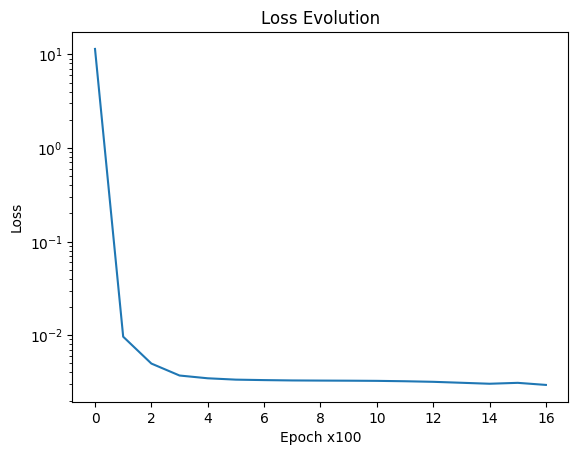

In [74]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

In [75]:
print(pde_loss(model, func, x,  sigma1=sigma1))
print(in_loss(model, func, T, sigma1, a))
print(out_loss(model, func, T, sigma1,  b))
print(time_loss(model, L))

6.2279116e-07
8.5689724e-05
2.5885058e-07
0.2862042


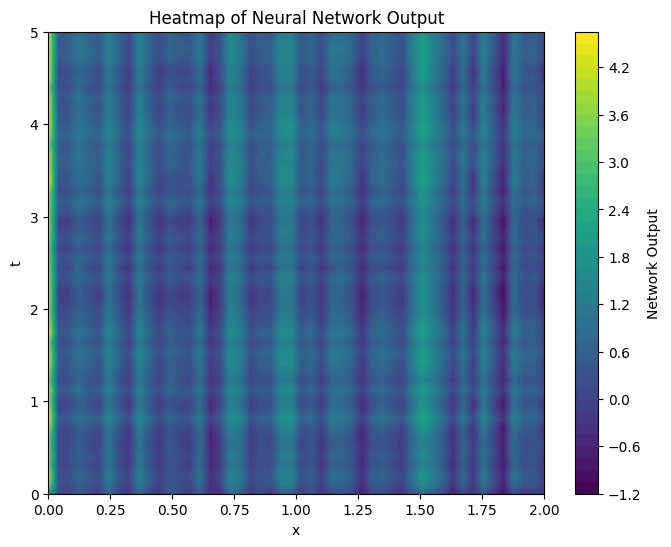

In [76]:
n_points = 50
x = jnp.linspace(0,L, n_points)
t = jnp.linspace(0,T, n_points)
X_grid, T_grid = jnp.meshgrid(x, t)
inputs = batch_fourier_encode(jnp.stack((X_grid.flatten(), T_grid.flatten()), axis=-1), encoding_degree)

outputs = jax.vmap(model)(inputs)
outputs = outputs.reshape(n_points, n_points)

plt.figure(figsize=(8, 6))
plt.contourf(X_grid, T_grid, outputs, levels=50, cmap='viridis')
plt.colorbar(label='Network Output')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Heatmap of Neural Network Output')
plt.show()

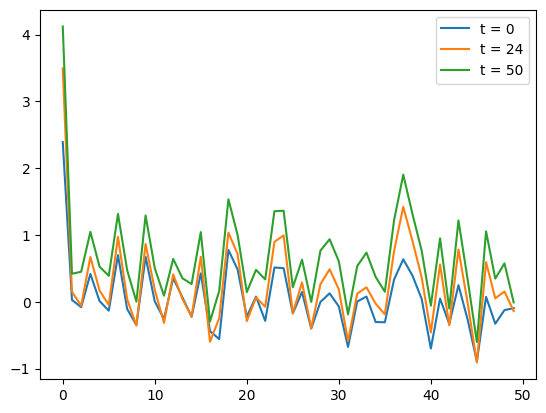

In [77]:
plt.plot(outputs[0], label='t = 0')
plt.plot(outputs[24], label='t = 24')
plt.plot(outputs[49], label='t = 50')
plt.legend()
plt.show()

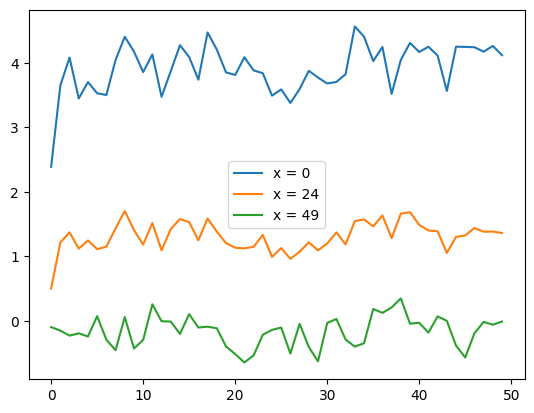

In [78]:
from cProfile import label


plt.plot(outputs.T[0], label='x = 0')
plt.plot(outputs.T[24], label='x = 24')
plt.plot(outputs.T[49], label='x = 49')
plt.legend()
plt.show()

In [79]:
len(outputs)

50